# Comparing Sentiment to Implied Volatility 

In [45]:
import numpy as np

import pandas as pd
import datetime as dt
import yfinance as yf

def options_chain(symbol):
    tk = yf.Ticker(symbol)
    
    expiration_dates = tk.options
    
    # Get options for each expiration
    options = pd.DataFrame()
    
    for e in expiration_dates:
        opt = tk.option_chain(e)
        #opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt = pd.concat([opt.calls, opt.puts], axis = 0)
        opt[['expirationDate']] = e
        #options = options.append(opt, ignore_index = True)
        options = pd.concat([options, opt], axis = 0)
    
    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + dt.timedelta(days = 1)
    options['dte'] = (options['expirationDate'] - dt.datetime.today()).dt.days / 365
    
    options['CALL'] = options['contractSymbol'].str[4:].apply(lambda x: "C" in x)
    
    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['mark'] = (options['bid'] + options['ask'])
    
    return options


In [57]:
tsla = yf.Ticker('TSLA')

tsla_options = tsla.option_chain()

tsla_options

Options(calls=         contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0   TSLA231208C00030000 2023-12-01 19:58:30+00:00    30.0     208.69  208.25   
1   TSLA231208C00040000 2023-11-29 20:46:26+00:00    40.0     203.73  198.25   
2   TSLA231208C00050000 2023-11-13 19:48:11+00:00    50.0     174.36  188.25   
3   TSLA231208C00080000 2023-11-30 19:43:54+00:00    80.0     155.04  158.30   
4   TSLA231208C00100000 2023-11-30 19:44:42+00:00   100.0     135.69  138.30   
..                  ...                       ...     ...        ...     ...   
73  TSLA231208C00420000 2023-11-21 16:52:30+00:00   420.0       0.01    0.00   
74  TSLA231208C00425000 2023-11-21 19:27:51+00:00   425.0       0.01    0.00   
75  TSLA231208C00430000 2023-11-20 14:43:59+00:00   430.0       0.01    0.00   
76  TSLA231208C00435000 2023-11-07 20:23:07+00:00   435.0       0.02    0.00   
77  TSLA231208C00440000 2023-11-30 15:42:17+00:00   440.0       0.01    0.00   

       ask    change  per

In [92]:
tech_news = pd.read_csv('tech_news_processed.csv')

tech_news['date'] = pd.to_datetime(tech_news['date'])

articles_2012_2015 = tech_news[(tech_news['date'].dt.year >= 2012) & (tech_news['date'].dt.year <= 2015)]


articles_2012_2015_std = articles_2012_2015.resample('1D', on='date')['Polarity'].std().reset_index()


articles_2012_2015_std.dropna(inplace=True)

articles_2012_2015_std.reset_index(drop=True, inplace=True)

articles_2012_2015_std





,date,Polarity
0,2012-01-28,0.224050
1,2012-01-29,0.000000
2,2012-02-04,0.440959
3,2012-02-05,0.058136
4,2012-02-11,0.234521
...,...,...
325,2015-12-23,0.048212
326,2015-12-28,0.390352
327,2015-12-29,0.325807
328,2015-12-30,0.074870


In [72]:

vix = yf.Ticker('^VIX')

start_date = dt.datetime(2012, 1, 1)
end_date = dt.datetime(2015, 12, 31)

vix_hist = vix.history(start=start_date, end=end_date).reset_index()



,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-03 00:00:00-06:00,22.950001,23.100000,22.540001,22.969999,0,0.0,0.0
1,2012-01-04 00:00:00-06:00,23.440001,23.730000,22.219999,22.219999,0,0.0,0.0
2,2012-01-05 00:00:00-06:00,22.750000,23.090000,21.340000,21.480000,0,0.0,0.0
3,2012-01-06 00:00:00-06:00,21.240000,21.719999,20.580000,20.629999,0,0.0,0.0
4,2012-01-09 00:00:00-06:00,21.670000,21.780001,21.000000,21.070000,0,0.0,0.0
...,...,...,...,...,...,...,...,...
1000,2015-12-23 00:00:00-06:00,15.860000,16.250000,15.330000,15.570000,0,0.0,0.0
1001,2015-12-24 00:00:00-06:00,15.440000,15.880000,14.450000,15.740000,0,0.0,0.0
1002,2015-12-28 00:00:00-06:00,17.650000,18.129999,16.879999,16.910000,0,0.0,0.0
1003,2015-12-29 00:00:00-06:00,15.910000,16.480000,15.630000,16.080000,0,0.0,0.0


In [97]:
merged = pd.concat([articles_2012_2015_std, vix_hist], axis=1)

In [99]:
merged.dropna(inplace=True)

merged

,date,Polarity,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-28,0.224050,2012-01-03 00:00:00-06:00,22.950001,23.100000,22.540001,22.969999,0,0.0,0.0
1,2012-01-29,0.000000,2012-01-04 00:00:00-06:00,23.440001,23.730000,22.219999,22.219999,0,0.0,0.0
2,2012-02-04,0.440959,2012-01-05 00:00:00-06:00,22.750000,23.090000,21.340000,21.480000,0,0.0,0.0
3,2012-02-05,0.058136,2012-01-06 00:00:00-06:00,21.240000,21.719999,20.580000,20.629999,0,0.0,0.0
4,2012-02-11,0.234521,2012-01-09 00:00:00-06:00,21.670000,21.780001,21.000000,21.070000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
325,2015-12-23,0.048212,2013-04-22 00:00:00-05:00,15.080000,16.000000,14.040000,14.390000,0,0.0,0.0
326,2015-12-28,0.390352,2013-04-23 00:00:00-05:00,13.810000,14.870000,13.460000,13.480000,0,0.0,0.0
327,2015-12-29,0.325807,2013-04-24 00:00:00-05:00,13.570000,13.750000,13.360000,13.610000,0,0.0,0.0
328,2015-12-30,0.074870,2013-04-25 00:00:00-05:00,13.610000,13.870000,13.130000,13.620000,0,0.0,0.0


In [103]:
import altair as alt 

alt.Chart(merged).mark_line().encode(
    x='Date',
    y='Close',
    color='Polarity'
)

alt.Chart(...)

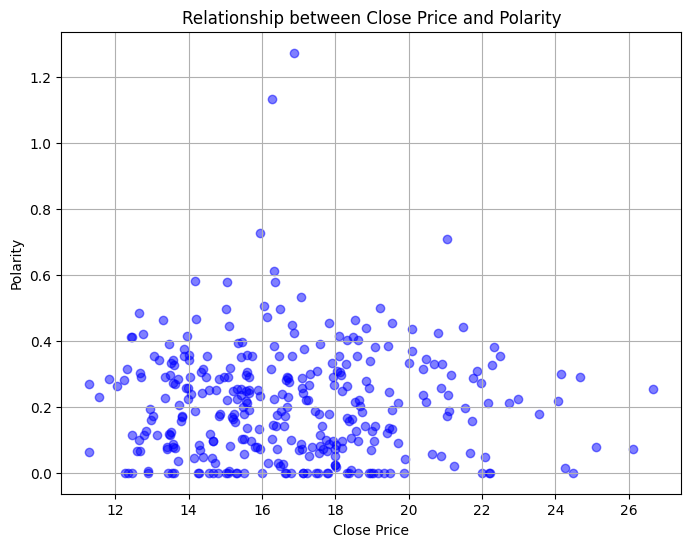

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(merged['Close'], merged['Polarity'], alpha=0.5, color='blue')

# Set plot labels and title
plt.title('Relationship between Close Price and Polarity')
plt.xlabel('Close Price')
plt.ylabel('Polarity')

# Show plot
plt.grid(True)
plt.show()

In [161]:
spyIV = pd.read_csv('HistoricalIV_SPY.csv')

In [106]:
spyIV

,Date,IV30,IV30 20-Day MA,OHLC 20-Day Vol,OHLC 52-Week Vol,Options Volume
0,12/1/2023,10.8200,11.5100,10.9898,14.6331,8330622.0
1,11/30/2023,10.7000,11.6535,11.3107,14.6387,7666927.0
2,11/29/2023,10.7200,11.8695,11.2081,14.6682,7663598.0
3,11/28/2023,10.2100,12.1385,11.5656,14.6663,6742061.0
4,11/27/2023,10.1800,12.4955,11.9775,14.6770,5676616.0
...,...,...,...,...,...,...
4734,1/14/2005,11.2243,11.8472,NaN,NaN,NaN
4735,1/13/2005,11.8837,12.0030,NaN,NaN,NaN
4736,1/12/2005,11.7508,12.0428,NaN,NaN,NaN
4737,1/11/2005,12.2296,12.1887,NaN,NaN,NaN


In [116]:
US_news = pd.read_csv('US_news_processed.csv')
business_news = pd.read_csv('business_news_processed.csv')


In [120]:
US_news['date'] = pd.to_datetime(US_news['Date'])

US_news.drop(columns=['Unnamed: 0', 'Date'], inplace=True)

US_news

,Heading,Article,Subjectivity,Polarity,Content Subjectivity,Content Polarity,date
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,0.000000,0.000000,0.377273,0.118182,2022-09-23
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,0.200000,0.100000,0.000000,0.000000,2022-09-23
2,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,0.266667,-0.233333,0.550000,-0.233333,2022-09-22
3,Cleaner Was Dead In Belk Bathroom For 4 Days B...,The 63-year-old woman was seen working at the ...,0.400000,-0.200000,0.225000,-0.200000,2022-09-22
4,Reporter Gets Adorable Surprise From Her Boyfr...,"""Who's that behind you?"" an anchor for New Yor...",0.750000,0.318182,0.577273,-0.131818,2022-09-22
...,...,...,...,...,...,...,...
1607,World Bank announces 57 bln in financing for Afri,strong>WASHINGTON: The World Bank on Sunday an...,0.000000,0.000000,0.416456,0.129798,2017-03-20
1608,Uber grounds self driving cars after accid,strong>WASHINGTON: Uber has grounded its fleet...,0.000000,0.000000,0.392063,-0.083730,2017-03-26
1609,Trump son in law 4 bn deal Chinese company,strong>WASHINGTON: A company owned by the fami...,0.000000,0.000000,0.388505,0.141968,2017-03-14
1610,World Bank announces 57 bln in financing for Afri,strong>WASHINGTON: The World Bank on Sunday an...,0.000000,0.000000,0.416456,0.129798,2017-03-20


In [121]:
combined_news = pd.concat([US_news, business_news, tech_news], axis=0)

In [123]:
combined_news.drop(columns=['Unnamed: 0', 'Heading', 'Article', 'short_description', 'headline', 'category'], inplace=True)

In [124]:
combined_news

,Subjectivity,Polarity,Content Subjectivity,Content Polarity,date
0,0.000000,0.000000,0.377273,0.118182,2022-09-23 00:00:00
1,0.200000,0.100000,0.000000,0.000000,2022-09-23 00:00:00
2,0.266667,-0.233333,0.550000,-0.233333,2022-09-22 00:00:00
3,0.400000,-0.200000,0.225000,-0.200000,2022-09-22 00:00:00
4,0.750000,0.318182,0.577273,-0.131818,2022-09-22 00:00:00
...,...,...,...,...,...
2098,0.500000,0.000000,0.517857,0.354911,2012-01-28 00:00:00
2099,0.000000,0.000000,0.295833,0.041667,2012-01-28 00:00:00
2100,0.207407,0.031481,0.411111,0.316667,2012-01-28 00:00:00
2101,0.500000,0.500000,0.633333,0.366667,2012-01-28 00:00:00


In [164]:
combined_news['date'] = pd.to_datetime(combined_news['date'])

oldest_date = combined_news['date'].min()
most_recent_date = combined_news['date'].max()

In [167]:
spyIV['Date'] = pd.to_datetime(spyIV['Date'])

spyIV = spyIV[(spyIV['Date'] >= oldest_date) & (spyIV['Date'] <= most_recent_date)].reset_index(drop=True)

spyIV

/var/folders/sf/kcx_s5bd0kj2xr6x7qk2t1c40000gn/T/ipykernel_37954/3990538781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spyIV['Date'] = pd.to_datetime(spyIV['Date'])


,Date,IV30,IV30 20-Day MA,OHLC 20-Day Vol,OHLC 52-Week Vol,Options Volume
0,2022-09-23,27.2500,23.3130,24.7004,21.9399,13803193.0
1,2022-09-22,25.2500,22.9190,24.6545,21.9436,8510835.0
2,2022-09-21,26.1400,22.6710,23.2973,21.8277,9723268.0
3,2022-09-20,25.1700,22.4105,23.6350,21.8820,6950163.0
4,2022-09-19,23.6600,22.1925,23.0622,21.8237,7426550.0
...,...,...,...,...,...,...
2659,2012-02-03,14.8038,16.8302,NaN,NaN,NaN
2660,2012-02-02,15.6365,17.0157,NaN,NaN,NaN
2661,2012-02-01,16.1945,17.1966,NaN,NaN,NaN
2662,2012-01-31,17.0607,17.3980,NaN,NaN,NaN


In [172]:
articles_std = combined_news.resample('1D', on='date')['Polarity'].std().reset_index()

articles_std.dropna(inplace=True)

articles_std

,date,Polarity
0,2012-01-28,0.207615
1,2012-01-29,0.317304
7,2012-02-04,0.300415
8,2012-02-05,0.213640
14,2012-02-11,0.257337
...,...,...
3884,2022-09-16,0.000000
3887,2022-09-19,0.141421
3889,2022-09-21,0.000000
3890,2022-09-22,0.309244


In [175]:
articles_std.rename(columns={'date': 'Date'}, inplace=True)

In [176]:
merged = pd.merge(spyIV, articles_std, on='Date')

In [178]:
merged

,Date,IV30,IV30 20-Day MA,OHLC 20-Day Vol,OHLC 52-Week Vol,Options Volume,Polarity
0,2022-09-23,27.2500,23.3130,24.7004,21.9399,13803193.0,0.070711
1,2022-09-22,25.2500,22.9190,24.6545,21.9436,8510835.0,0.309244
2,2022-09-21,26.1400,22.6710,23.2973,21.8277,9723268.0,0.000000
3,2022-09-19,23.6600,22.1925,23.0622,21.8237,7426550.0,0.141421
4,2022-09-16,24.3600,21.9105,22.6759,21.7987,10659577.0,0.000000
...,...,...,...,...,...,...,...
1293,2012-03-06,16.5826,15.5209,NaN,NaN,NaN,0.229819
1294,2012-03-05,14.3891,15.4710,NaN,NaN,NaN,0.364837
1295,2012-03-02,13.7901,15.4917,NaN,NaN,NaN,0.376466
1296,2012-03-01,13.9527,15.5841,NaN,NaN,NaN,0.242065


In [195]:

alt.Chart(merged).mark_point().encode(
    x='Date',
    y='IV30 20-Day MA',
    color=alt.Color('Polarity').scale(scheme="redyellowblue")   
)

alt.Chart(...)